In [1]:
cd ../../task_01/pipelines

/home/tristan/Documents/ethz/master/second_year/first_semester/dsl/data_sc_lab/task_01/pipelines


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipynb.fs.full.tool_functions import *
from yellowbrick.regressor import AlphaSelection

/home/tristan/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [3]:
df_beha = pd.read_csv('../../../data/Behavioral/AllData.csv')#, nrows=1000)

df_psd_cluster = pd.read_csv("../../../data/EEG/RestingEEG_PSD_Cluster.csv") #, nrows=1000)
df_psd_channel = pd.read_csv("../../../data/EEG/RestingEEG_PSD_Channel.csv") #, nrows=5)
df_spectro_cluster = pd.read_csv("../../../data/EEG/RestingEEG_Spectro_Cluster.csv") #, nrows=1000)
df_spectro_channel = pd.read_csv("../../../data/EEG/RestingEEG_Spectro_Channel.csv") #, nrows=5)

df_microstate = pd.read_csv("../../../data/EEG/RestingEEG_Microstates.csv") #, nrows=5)

/home/tristan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (66,68,80,81,82,83,84,95,96,97,98,99,110,111,112,113,114,125,126,127,128,129,140,141,142,144,155,156,157,159,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1

In [4]:
# Extract relevant info from the Behavioral data 
y_labels = df_beha[["Patient_ID", "Age", "DX_01_Cat"]]
y_labels_healthy = y_labels[y_labels["DX_01_Cat"].str.contains("No Diagnosis Given") == True]

y_labels = y_labels[["Patient_ID", "Age"]]
y_labels_healthy = y_labels_healthy[["Patient_ID", "Age"]]
y_labels_healthy

,Patient_ID,Age
9,NDARCF462HNM,14.216632
11,NDARFC233RND,9.153661
22,NDARDT800YVF,17.510381
25,NDARZT011LBZ,7.760209
26,NDARKV482FU9,10.977298
...,...,...
2088,NDARAV069HGT,13.896189
2089,NDARZC497BFU,17.419917
2090,NDARDZ737LG9,13.031143
2094,NDARRT283RHB,10.712069


In [5]:
df_psd_cluster.rename(columns={'id': 'Patient_ID'}, inplace=True)
df_spectro_cluster.rename(columns={'id': 'Patient_ID'}, inplace=True)
df_microstate.rename(columns={'id': 'Patient_ID'}, inplace=True)
print("Original lengths: " + str(len(df_psd_cluster)) + "(psd), " + \
     str(len(df_spectro_cluster)) + "(spectro), " + str(len(df_microstate)) + "(micro)")

# Aggregate with label
df_label_psd_cluster = pd.merge(y_labels_healthy, df_psd_cluster, on='Patient_ID')
df_label_spectro_cluster = pd.merge(y_labels_healthy, df_spectro_cluster, on='Patient_ID')
df_label_microstate = pd.merge(y_labels_healthy, df_microstate, on='Patient_ID')
print("Only healthy people, resulting lengths: " + str(len(df_label_psd_cluster)) + "(psd), " + \
     str(len(df_label_spectro_cluster)) + "(spectro), " + str(len(df_label_microstate)) + "(micro)")

# Drop NaN values
df_label_psd_cluster = fill_with_median(df_label_psd_cluster)
df_label_spectro_cluster = fill_with_median(df_label_spectro_cluster)
df_label_microstate = fill_with_median(df_label_microstate)
print("Replace NaN by median, resulting lenghts: " + str(len(df_label_psd_cluster)) + "(psd), " + \
     str(len(df_label_spectro_cluster)) + "(spectro), " + str(len(df_label_microstate)) + "(micro)")

Original lengths: 1485(psd), 1485(spectro), 1108(micro)
Only healthy people, resulting lengths: 174(psd), 174(spectro), 128(micro)
Replace NaN by median, resulting lenghts: 174(psd), 174(spectro), 128(micro)


In [6]:
less_18 = df_label_spectro_cluster['Age'] <= 18.0

In [7]:
df_label_spectro_cluster = df_label_spectro_cluster[less_18]

In [8]:
test_ratio = 0.2

In [9]:
# Define Train and Test data 
print()
print("---- Split into Train and Test data ----")
print()

from sklearn.model_selection import train_test_split
x_train , x_test, y_train , y_test = \
train_test_split(df_label_spectro_cluster.drop(['Age', 'Patient_ID'], axis=1), df_label_spectro_cluster[['Age']], test_size=0.2, random_state = 0)




---- Split into Train and Test data ----



In [10]:
forest = IsolationForest()
forest.fit(x_train)

# Outlier indices for training
outliers_training = forest.predict(x_train)
outliers_training_indices = np.argwhere(outliers_training == 1).flatten()

# Drop signal outliers in training data
x_train = x_train[outliers_training == 1]
y_train = y_train[outliers_training == 1]
#x_train, y_train = drop_outliers_samples_isolation_forest(x_train, y_train)
print(outliers_training_indices)
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  27  28  29  30  31  33  34  37  38  39  42
  43  44  45  46  47  48  49  50  51  52  53  54  56  58  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  82
  83  84  85  86  87  88  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 130 131 132 133]
(34, 300)
(34, 1)
(120, 300)
(120, 1)


In [11]:
# Feature Scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)

print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

(34, 300)
(34, 1)
(120, 300)
(120, 1)


In [12]:
rdf = fit_random_forest_with_grid_search(x_train, y_train)

/home/tristan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/tristan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best parameters for Random Forest: {'max_depth': 15, 'max_leaf_nodes': 200, 'min_samples_split': 3, 'n_estimators': 1000}


In [13]:
rdf.best_params_

{'max_depth': 15,
 'max_leaf_nodes': 200,
 'min_samples_split': 3,
 'n_estimators': 1000}

In [14]:
rdf.best_score_

-5.8016351730970515

In [16]:
mean_squared_error(y_test , rdf.predict(x_test))

4.9536313395007765

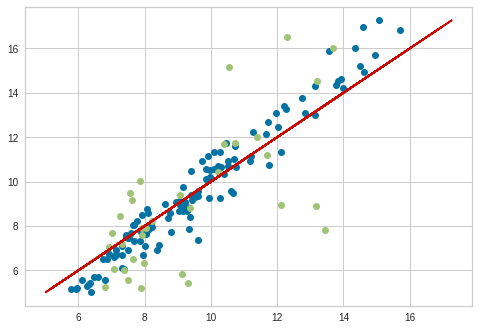

In [17]:
plt.plot(rdf.predict(x_train) , y_train , 'o')
plt.plot(rdf.predict(x_test), y_test , 'o')
plt.plot(y_train , y_train)

# Analyse residual distributions

In [177]:
# Healthy people 
residuals_healthy = np.asarray(y_test).flatten() - rdf.predict(x_test)

In [178]:
# DX_01 ADHD people
y_adhd_dx_01 = df_beha[df_beha["DX_01"].str.contains("ADHD") == True]
y_adhd_dx_01 = y_adhd_dx_01[["Patient_ID", "Age"]]

X_adhd_dx_01 = pd.merge(y_adhd_dx_01, df_spectro_cluster, on='Patient_ID')
y_adhd_dx_01 = X_adhd_dx_01["Age"]
X_adhd_dx_01 = fill_with_median(X_adhd_dx_01.iloc[:,2:])

residuals_adhd_dx_01 = np.asarray(y_adhd_dx_01).flatten() - rdf.predict(X_adhd_dx_01)

In [179]:
# DX_02 ADHD people
y_adhd_dx_02 = df_beha[df_beha["DX_02"].str.contains("ADHD") == True]
y_adhd_dx_02 = y_adhd_dx_02[["Patient_ID", "Age"]]

X_adhd_dx_02 = pd.merge(y_adhd_dx_02, df_spectro_cluster, on='Patient_ID')
y_adhd_dx_02 = X_adhd_dx_02["Age"]
X_adhd_dx_02 = fill_with_median(X_adhd_dx_02.iloc[:,2:])

residuals_adhd_dx_02 = np.asarray(y_adhd_dx_02).flatten() - rdf.predict(X_adhd_dx_02)

In [180]:
# DX_03 ADHD people
y_adhd_dx_03 = df_beha[df_beha["DX_03"].str.contains("ADHD") == True]
y_adhd_dx_03 = y_adhd_dx_03[["Patient_ID", "Age"]]

X_adhd_dx_03 = pd.merge(y_adhd_dx_03, df_spectro_cluster, on='Patient_ID')
y_adhd_dx_03 = X_adhd_dx_03["Age"]
X_adhd_dx_03 = fill_with_median(X_adhd_dx_03.iloc[:,2:])

residuals_adhd_dx_03 = np.asarray(y_adhd_dx_03).flatten() - rdf.predict(X_adhd_dx_03)

/home/tristan/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/tristan/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/tristan/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

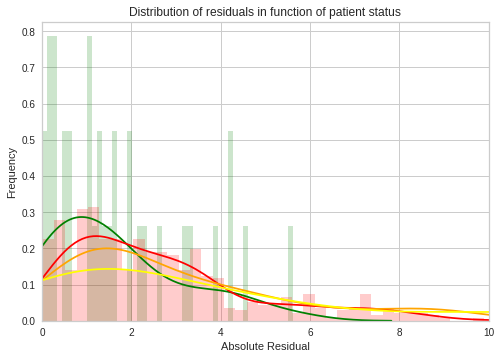

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(np.abs(residuals_healthy), 50, facecolor='green', density=True, alpha=0.2)
plt.hist(np.abs(residuals_adhd_dx_01), 50, facecolor='red',density=True, alpha=0.2)
plt.hist(np.abs(residuals_adhd_dx_02), 50, facecolor='orange',density=True, alpha=0)
plt.hist(np.abs(residuals_adhd_dx_03), 50, facecolor='yellow',density=True, alpha=0)

sns.distplot(np.abs(residuals_healthy), hist = False, color = 'green')
sns.distplot(np.abs(residuals_adhd_dx_01), hist = False, color = 'red')
sns.distplot(np.abs(residuals_adhd_dx_02), hist = False, color = 'orange')
sns.distplot(np.abs(residuals_adhd_dx_03), hist = False, color = 'yellow')

plt.xlim((0, 10)) 

plt.xlabel('Absolute Residual')
plt.ylabel('Frequency')
plt.title('Distribution of residuals in function of patient status')
plt.show()

In [171]:
# With non absolute value this time
mean_residuals_healthy = np.mean(residuals_healthy)
sqrt_var_residuals_healthy = np.sqrt(np.var(residuals_healthy))

residuals_healthy = (residuals_healthy - mean_residuals_healthy)/sqrt_var_residuals_healthy
residuals_adhd_dx_01 = (residuals_adhd_dx_01 - mean_residuals_healthy)/sqrt_var_residuals_healthy
residuals_adhd_dx_02 = (residuals_adhd_dx_02 - mean_residuals_healthy)/sqrt_var_residuals_healthy
residuals_adhd_dx_03 = (residuals_adhd_dx_03 - mean_residuals_healthy)/sqrt_var_residuals_healthy

/home/tristan/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/tristan/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/tristan/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

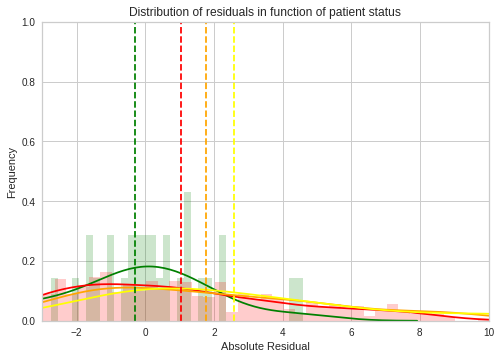

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(residuals_healthy, 50, facecolor='green', density=True, alpha=0.2)
plt.hist(residuals_adhd_dx_01, 50, facecolor='red',density=True, alpha=0.2)
plt.hist(residuals_adhd_dx_02, 50, facecolor='orange',density=True, alpha=0)
plt.hist(residuals_adhd_dx_03, 50, facecolor='yellow',density=True, alpha=0)

sns.distplot(residuals_healthy, hist = False, color = 'green')
sns.distplot(residuals_adhd_dx_01, hist = False, color = 'red')
sns.distplot(residuals_adhd_dx_02, hist = False, color = 'orange')
sns.distplot(residuals_adhd_dx_03, hist = False, color = 'yellow')

plt.axvline(x=np.mean(residuals_healthy), color='green', linestyle='--')
plt.axvline(x=np.mean(residuals_adhd_dx_01), color='red', linestyle='--')
plt.axvline(x=np.mean(residuals_adhd_dx_02), color='orange', linestyle='--')
plt.axvline(x=np.mean(residuals_adhd_dx_03), color='yellow', linestyle='--')

plt.xlim((-3, 10)) 
plt.ylim((0, 1.0))

plt.xlabel('Absolute Residual')
plt.ylabel('Frequency')
plt.title('Distribution of residuals in function of patient status')
plt.show()